# Importing Libraries

In [19]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [20]:
import classes.file_loader as file_loader
import classes.linear_time_series as linear_time_series
import classes.tools as tools
import classes.gated_reccurent_unit as gated_reccurent_unit
import classes.long_short_term_memory as long_short_term_memory

# Data Preprocessing

## Loading Files

In [21]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [22]:
warnings.filterwarnings("ignore")

classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

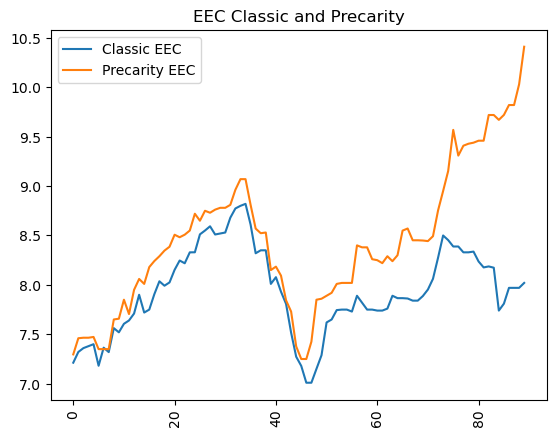

In [23]:
plt.figure()

plt.plot(classic_raw_df["SPOT"], label = "Classic EEC")
plt.plot(preacarity_raw_df["SPOT"], label = "Precarity EEC")
plt.title("EEC Classic and Precarity")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

In [24]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [25]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [26]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.217597
2,2023-04-26,7.214516
3,2023-04-27,7.231697
4,2023-04-28,7.260163
...,...,...
446,2025-01-07,7.947758
447,2025-01-08,7.968983
448,2025-01-09,7.996396
449,2025-01-10,8.008248


In [27]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.292625
2,2023-04-26,7.322997
3,2023-04-27,7.409030
4,2023-04-28,7.405078
...,...,...
446,2025-01-07,10.156671
447,2025-01-08,10.149731
448,2025-01-09,10.086286
449,2025-01-10,10.170083


## Plotting the selected augmented dataframes 

We select one iteration of fir the classic and precarirty dataframe.

In [28]:
classic_df = pd.read_csv("selected_augmented_classic_df.csv")
precarity_df = pd.read_csv("selected_augmented_precarity_df.csv")

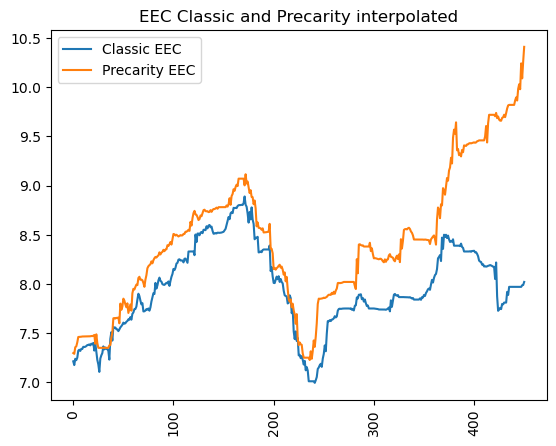

In [29]:
plt.figure()

plt.plot(classic_df["SPOT"], label = "Classic EEC")
plt.plot(precarity_df["SPOT"], label = "Precarity EEC")
plt.title("EEC Classic and Precarity interpolated")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

Now we will separate data between data that will be used to train our models and the data which will be used to test our trading strategies.

From the graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [30]:
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.174503,-0.038213
2,2023-04-26,7.238924,0.064421
3,2023-04-27,7.224501,-0.014423
4,2023-04-28,7.249729,0.025228
5,2023-05-01,7.321166,0.071437
...,...,...,...
446,2025-01-07,7.969759,-0.000241
447,2025-01-08,7.969839,0.000079
448,2025-01-09,7.986663,0.016825
449,2025-01-10,7.988577,0.001914


Neural Networks do not necessarily need stationnary data. However they perform better on normalized data. Hence we create the normalized data using Min-Max Scaler as the data is not normally distributed :

In [31]:
minmax_scaler = MinMaxScaler()
classic_df["Normalized Spot"] = minmax_scaler.fit_transform(classic_df[["SPOT"]])
classic_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


In [32]:
classic_development_df, classic_test_df = classic_df[:int(0.80*len(classic_df))], classic_df[int(0.80*len(classic_df)):]

In [33]:
classic_development_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
356,2024-09-03,7.939913,-0.013183,0.499213
357,2024-09-04,7.993982,0.054069,0.527747
358,2024-09-05,8.041032,0.047050,0.552578
359,2024-09-06,8.013912,-0.027120,0.538266


In [34]:
classic_test_df

,Date,SPOT,Delta,Normalized Spot
361,2024-09-10,8.089756,0.028217,0.578292
362,2024-09-11,8.101701,0.011945,0.584596
363,2024-09-12,8.149817,0.048116,0.609989
364,2024-09-13,8.259876,0.110059,0.668073
365,2024-09-16,8.274618,0.014742,0.675853
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


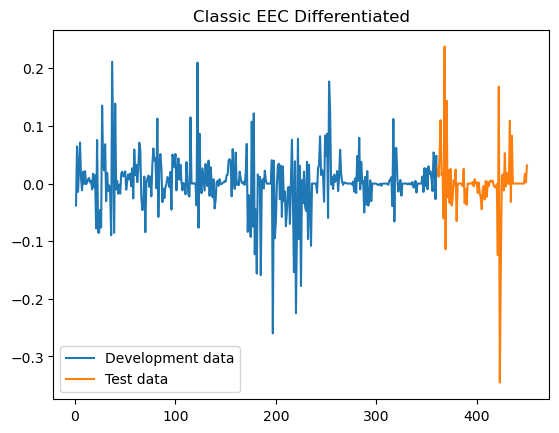

In [35]:
plt.figure()
plt.plot(classic_development_df["Delta"], label="Development data")
plt.plot(classic_test_df["Delta"], label="Test data")
plt.title("Classic EEC Differentiated")
plt.legend()
plt.show()

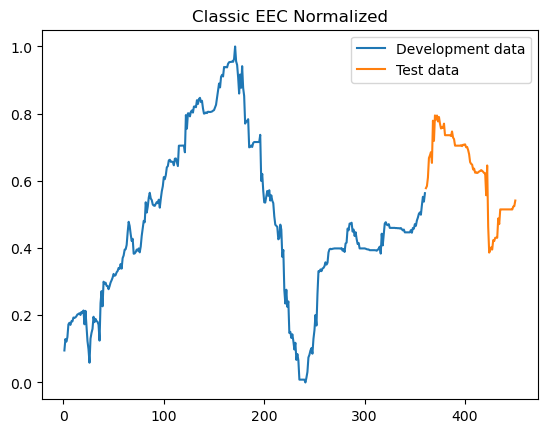

In [36]:
plt.figure()
plt.plot(classic_development_df["Normalized Spot"], label="Development data")
plt.plot(classic_test_df["Normalized Spot"], label="Test data")
plt.title("Classic EEC Normalized")
plt.legend()
plt.show()

# Data forecasting

## Classic EEC

### ARMA

We create an ARMA model (in reality ARIMA as the series was already differentiated), using a class built on our own.

In [37]:
result = adfuller(classic_development_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 8.410526298029595e-14
Result: reject unit root -> series is stationary (at 5% level).


In [38]:
# Initiate the ARMA class

LinearTimeSeriesModel = linear_time_series.LinearTimeSeriesModel(classic_development_df["Delta"])

In [39]:
# Selecting the last relevant lags

LinearTimeSeriesModel.get_ma_max_order()
LinearTimeSeriesModel.get_ar_max_order()
print(f"Max MA order: {LinearTimeSeriesModel.ma_max_order}, Max AR order: {LinearTimeSeriesModel.ar_max_order}")

Max MA order: 2, Max AR order: 3


In [40]:
# Selecting the best model according to AIC using the maximum relevant lags

selected_models = LinearTimeSeriesModel.select_model()
selected_models["aicc"]

The p-value of the L-JungBox test is 0.0010769501074859085 for the model ARIMA(0,0,0) with AIC = -865.2753020188438
The p-value of the L-JungBox test is 0.00019603097391517166 for the model ARIMA(1,0,0) with AIC = -868.69992441343
The p-value of the L-JungBox test is 0.16297763067651264 for the model ARIMA(2,0,0) with AIC = -876.2575485804443
The p-value of the L-JungBox test is 0.7157039278648097 for the model ARIMA(3,0,0) with AIC = -880.2907981667475
The p-value of the L-JungBox test is 0.00035552134321538046 for the model ARIMA(0,0,1) with AIC = -867.1486027223268
The p-value of the L-JungBox test is 0.0009961180754488983 for the model ARIMA(1,0,1) with AIC = -869.6690742834805
The p-value of the L-JungBox test is 0.9172372269960318 for the model ARIMA(2,0,1) with AIC = -883.1324185445949
The p-value of the L-JungBox test is 0.9437340891958436 for the model ARIMA(3,0,1) with AIC = -881.5936067228174
The p-value of the L-JungBox test is 0.28029800966799606 for the model ARIMA(0,0,2)

{'order': (2, 0, 1), 'aicc': -882.9196525871481}

In [41]:
# Prediction using our model
train_pred, validation_pred = LinearTimeSeriesModel.model_prediction()

# Cumulative sum to get back to the original scale
cum_train_pred = np.cumsum(train_pred) + classic_development_df["SPOT"].iloc[0]
cum_train_real = np.cumsum(LinearTimeSeriesModel.train_dependent) + classic_development_df["SPOT"].iloc[0]

cum_validation_pred = np.cumsum(validation_pred) + cum_train_pred.iloc[-1]
cum_validation_real = np.cumsum(LinearTimeSeriesModel.validation_dependent) + classic_development_df["SPOT"].iloc[0]

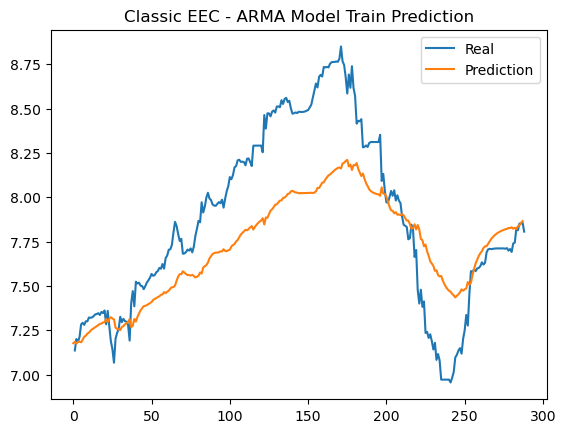

In [42]:
plt.figure()
plt.title("Classic EEC - ARMA Model Train Prediction")
plt.plot(cum_train_real, label="Real")
plt.plot(cum_train_pred, label="Prediction")
plt.legend()
plt.show()

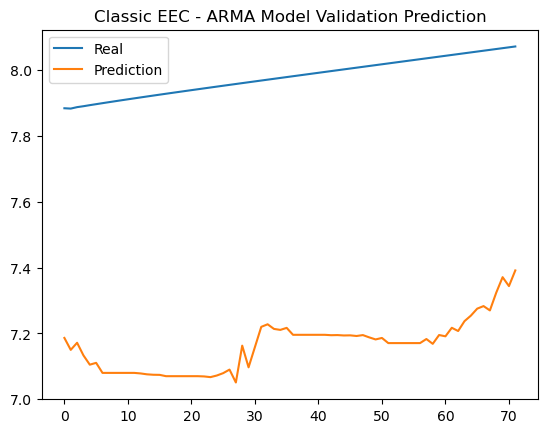

In [57]:
plt.figure()
plt.title("Classic EEC - ARMA Model Validation Prediction")
plt.plot(cum_validation_pred.reset_index(drop=True), label="Real")
plt.plot(cum_validation_real, label="Prediction")
plt.legend()
plt.show()

In [44]:
# Asssessing performances of ARIMA model
arima_model_metrics = tools.model_metrics(cum_train_real, cum_train_pred, cum_validation_real, cum_validation_pred)

all_metrics = arima_model_metrics.get_all_metrics()

print(all_metrics["train"])

print(all_metrics["validation"])

{'mae': 0.2730466389385462, 'rmse': 0.3385583106514087, 'mse': 0.11462172971113574, 'mape': 3.4013534814716833, 'r2': 0.5606640317756916}
{'mae': nan, 'rmse': 0.8169689412986304, 'mse': 0.667438251046605, 'mape': nan, 'r2': 1.0}


### RNN

Parameters to optimize :

-   Lookback : Number of points used to predict the next oneNombre de points utilisés pour prédire le point suivant
-   Hidden size : Number of GRU cells per layer
-   Number of layers : Number of layers

#### Gated Reccurent Unit (GRU)

In [45]:
# Initializing the GRU class
GRU = gated_reccurent_unit.GRU(classic_development_df["Normalized Spot"], train_test_ratio=0.8)

##### Tuning Training Parameters

In [46]:
train_param_grid = {
    "l2" : [1e-02, 1e-03, 1e-04, 1e-05, 1e-06],
    "lrs" : [1, 0.1, 0.01, 0.001],
    "epochs" : [20, 30, 40, 60, 80, 100, 120, 140],
    "epochs_mid" : 80,
    "patience": 10,
    "min_delta": 1e-4,
    "n_splits": 5,
    "val_size": 200,
    "min_train_size" : 50     
}

model_param = {
    "lookback": 40,
    "hidden_size": 16,
    "num_layers": 1,
}
GRU_training_aprams = GRU.tune_train(train_param_grid, model_param)

GRU.training_params

Training results: cv_mse : 0.03447005897760391, val_size : 200, n_splits : 5


{'lr': 0.1, 'l2': 0.0001, 'epochs': 60}

##### Tuning Model Parameters

In [47]:
model_param_grid = {
    "lookback": [int(x) for x in np.linspace(10, 70, 6)],
    "hidden_size": [2, 4, 8, 16],
    "num_layers": [1, 2],
}
GRU.tune_model(model_param_grid)

lookback=10, hidden=2, layers=1 → MSE=0.000356
lookback=10, hidden=2, layers=2 → MSE=0.000194
lookback=10, hidden=4, layers=1 → MSE=0.000627
lookback=10, hidden=4, layers=2 → MSE=0.000316
lookback=10, hidden=8, layers=1 → MSE=0.000196
lookback=10, hidden=8, layers=2 → MSE=0.000156
lookback=10, hidden=16, layers=1 → MSE=0.000309
lookback=10, hidden=16, layers=2 → MSE=0.000160
lookback=22, hidden=2, layers=1 → MSE=0.000164
lookback=22, hidden=2, layers=2 → MSE=0.000336
lookback=22, hidden=4, layers=1 → MSE=0.000377
lookback=22, hidden=4, layers=2 → MSE=0.000164
lookback=22, hidden=8, layers=1 → MSE=0.000181
lookback=22, hidden=8, layers=2 → MSE=0.000353
lookback=22, hidden=16, layers=1 → MSE=0.000966
lookback=22, hidden=16, layers=2 → MSE=0.001075
lookback=34, hidden=2, layers=1 → MSE=0.000157
lookback=34, hidden=2, layers=2 → MSE=0.010202
lookback=34, hidden=4, layers=1 → MSE=0.000168
lookback=34, hidden=4, layers=2 → MSE=0.000404
lookback=34, hidden=8, layers=1 → MSE=0.000301
lookback=

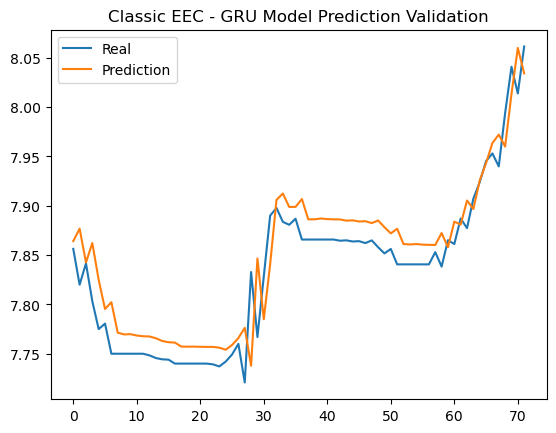

In [48]:
data_type = "validation"
y_pre_validation, y = GRU.predict(data=data_type)
y_pre_validation, y = minmax_scaler.inverse_transform(y_pre_validation.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - GRU Model Prediction Validation")
plt.plot(y, label="Real")
plt.plot(y_pre_validation, label="Prediction")
plt.legend()
plt.show()

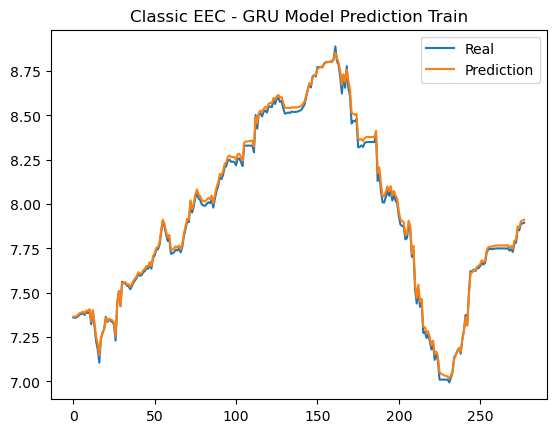

In [49]:
data_type = "train"
y_pred_train, y = GRU.predict(data=data_type)
y_pred_train, y = minmax_scaler.inverse_transform(y_pred_train.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - GRU Model Prediction Train")
plt.plot(y, label="Real")
plt.plot(y_pred_train, label="Prediction")
plt.legend()
plt.show()

#### LSTM

In [50]:
# Initializing the LSTM class

LSTM = long_short_term_memory.LSTM(classic_development_df["Normalized Spot"], train_test_ratio=0.8)

##### Tuning Training Parameters

In [51]:
train_param_grid = {
    "l2" : [1e-02, 1e-03, 1e-04, 1e-05, 1e-06],
    "lrs" : [1, 0.1, 0.01, 0.001],
    "epochs" : [20, 30, 40, 60, 80, 100, 120, 140, 150, 160],
    "epochs_mid" : 80,
    "patience": 10,
    "min_delta": 1e-4,
    "n_splits": 5,
    "val_size": 200,
    "min_train_size" : 50     
}

model_param = {
    "lookback": 40,
    "hidden_size": 16,
    "num_layers": 1,
}

LSTM_training_params = LSTM.tune_train(train_param_grid, model_param)

LSTM.training_params

Training results: cv_mse : 0.08057810366153717, val_size : 200, n_splits : 5


{'lr': 0.1, 'l2': 0.001, 'epochs': 80}

##### Tuning Model Parameters

In [52]:
model_param_grid = {
    "lookback": [int(x) for x in np.linspace(10, 70, 6)],
    "hidden_size": [2, 4, 8, 16],
    "num_layers": [1, 2],
}
LSTM.tune_model(model_param_grid)

lookback=10, hidden=2, layers=1 → MSE=0.001118
lookback=10, hidden=2, layers=2 → MSE=0.003526
lookback=10, hidden=4, layers=1 → MSE=0.000197
lookback=10, hidden=4, layers=2 → MSE=0.000314
lookback=10, hidden=8, layers=1 → MSE=0.005249
lookback=10, hidden=8, layers=2 → MSE=0.001207
lookback=10, hidden=16, layers=1 → MSE=0.000208
lookback=10, hidden=16, layers=2 → MSE=0.003286
lookback=22, hidden=2, layers=1 → MSE=0.000347
lookback=22, hidden=2, layers=2 → MSE=0.000232
lookback=22, hidden=4, layers=1 → MSE=0.000163
lookback=22, hidden=4, layers=2 → MSE=0.000635
lookback=22, hidden=8, layers=1 → MSE=0.006959
lookback=22, hidden=8, layers=2 → MSE=0.000316
lookback=22, hidden=16, layers=1 → MSE=0.000163
lookback=22, hidden=16, layers=2 → MSE=0.000649
lookback=34, hidden=2, layers=1 → MSE=0.000202
lookback=34, hidden=2, layers=2 → MSE=0.005131
lookback=34, hidden=4, layers=1 → MSE=0.000253
lookback=34, hidden=4, layers=2 → MSE=0.001336
lookback=34, hidden=8, layers=1 → MSE=0.000172
lookback=

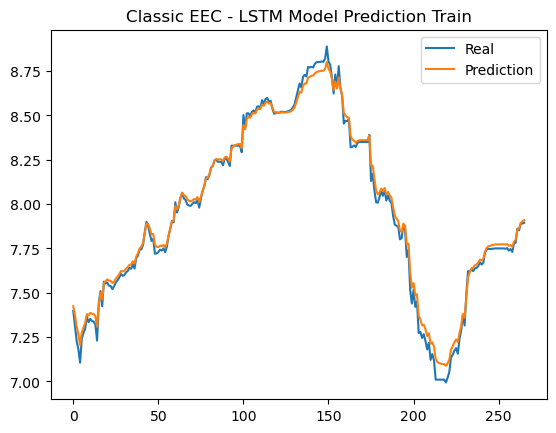

In [53]:
data_type = "train"
y_pre_train, y = LSTM.predict(data=data_type)
y_pre_train, y = minmax_scaler.inverse_transform(y_pre_train.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - LSTM Model Prediction Train")
plt.plot(y, label="Real")
plt.plot(y_pre_train, label="Prediction")
plt.legend()
plt.show()

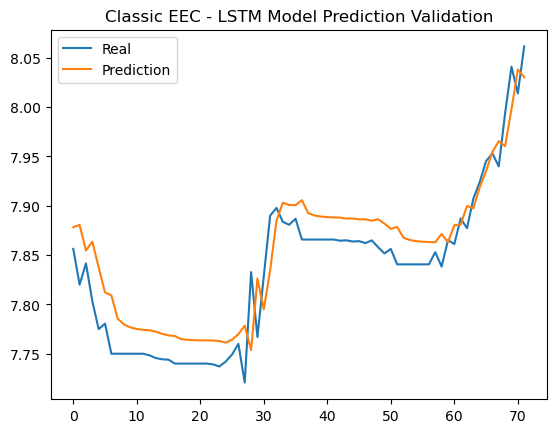

In [54]:
data_type = "validation"
y_pre_validation, y = LSTM.predict(data=data_type)
y_pre_validation, y = minmax_scaler.inverse_transform(y_pre_validation.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - LSTM Model Prediction Validation")
plt.plot(y, label="Real")
plt.plot(y_pre_validation, label="Prediction")
plt.legend()
plt.show()

### Forecast

We will go through the classic_test_df which is data that has never been seen by our model. We will :
* Iterate through every week, each 5 business days actually
* Calibrate the model parameters
* Try to forecast the price of the following week

In [35]:
# Walk-forward weekly forecasting on the unseen test set
# - ARIMA (on Delta → integrated back to SPOT)
# - GRU (on Normalized Spot → inverse-scaled to SPOT)
# - LSTM (on Normalized Spot → inverse-scaled to SPOT)

arma_weekly_preds = pd.Series(index=classic_test_df.index, dtype=float)
gru_weekly_preds  = pd.Series(index=classic_test_df.index, dtype=float)
lstm_weekly_preds = pd.Series(index=classic_test_df.index, dtype=float)

# We will always re-fit on all data seen up to the *start* of each week,
# then forecast the *next* 5 business days (if available).
week_size = 5

for wk_start in range(0, len(classic_test_df), week_size):
    print(f"\n\nWeek {(wk_start + 1)/week_size}/{len(classic_test_df)/week_size}\n\n")

    wk_end = wk_start + week_size
    next_wk_end = wk_end + week_size

    # If we don't have a full “next week” to forecast, stop here.
    if next_wk_end > len(classic_test_df):
        break

    # Data seen so far (development + already observed test weeks)
    seen_df = pd.concat(
        [classic_development_df, classic_test_df.iloc[:wk_end]],
        axis=0
    )

    # The *next* week to forecast (targets we will compare with later)
    next_week_idx = classic_test_df.iloc[wk_end:next_wk_end].index

    # -------------------------
    # ARMA / ARIMA on Delta
    # -------------------------
    # Calibrate max AR/MA orders, select best model (AICc + Ljung-Box), then forecast next 5 deltas
    arma_model = linear_time_series.LinearTimeSeriesModel(seen_df["Delta"])
    arma_model.get_ma_max_order()
    arma_model.get_ar_max_order()
    arma_model.select_model()  # picks ARIMA(p,0,q) with diagnostic check and best AICc
    # Forecast 5 steps ahead beyond the end of the seen series (out-of-sample)
    start = len(arma_model.dependent_time_series)
    end   = start + week_size - 1
    delta_forecast = arma_model.model_prediction(start_index=start, end_index=end)  # 5-step Δ forecast  :contentReference[oaicite:0]{index=0}

    # Convert Δ → SPOT by integrating from the last known SPOT level
    last_spot_level = seen_df["SPOT"].iloc[-1]
    arma_spot_week = last_spot_level + np.cumsum(np.array(delta_forecast, dtype=float))
    arma_weekly_preds.loc[next_week_idx] = arma_spot_week

    
    # GRU on Normalized Spot

    # Re-initialize on all seen normalized data, tune, and forecast 5 steps
    gru_model = gated_reccurent_unit.GRU(seen_df["Normalized Spot"], train_test_ratio=0.8)

    gru_model.tune_train(train_param_grid, model_param)
    gru_model.tune_model(model_param_grid)  # sets gru_model.model_params and trains final model  :contentReference[oaicite:1]{index=1}
    gru_norm_forecast = gru_model.predict_future(days=week_size)  # normalized units  :contentReference[oaicite:2]{index=2}
    gru_spot_week = minmax_scaler.inverse_transform(gru_norm_forecast.reshape(-1, 1)).ravel()
    gru_weekly_preds.loc[next_week_idx] = gru_spot_week

    # LSTM on Normalized Spot
    # -------------------------
    lstm_model = long_short_term_memory.LSTM(seen_df["Normalized Spot"], train_test_ratio=0.8)

    lstm_model.tune_train(train_param_grid, model_param)
    lstm_model.tune_model(model_param_grid)  # sets lstm_model.model_params and trains final model  :contentReference[oaicite:3]{index=3}
    lstm_norm_forecast = lstm_model.predict_future(days=week_size)  # normalized units  :contentReference[oaicite:4]{index=4}
    lstm_spot_week = minmax_scaler.inverse_transform(lstm_norm_forecast.reshape(-1, 1)).ravel()
    lstm_weekly_preds.loc[next_week_idx] = lstm_spot_week

# -------------------------
# Collect results and (optionally) visualize
# -------------------------
weekly_forecasts = pd.DataFrame({
    "ARIMA_SPOT": arma_weekly_preds,
    "GRU_SPOT":   gru_weekly_preds,
    "LSTM_SPOT":  lstm_weekly_preds,
    "REAL_SPOT":  classic_test_df["SPOT"]
}).dropna(how="all")

display(weekly_forecasts.head(15))

weekly_forecasts.to_csv("weekly_forecast.csv")



Week 0.0/18.0


The p-value of the L-JungBox test is 0.0010420053875632908 for the model ARIMA(0,0,0) with AIC = -880.1090205776518
The p-value of the L-JungBox test is 0.00018593950263775613 for the model ARIMA(1,0,0) with AIC = -883.7893174833445
The p-value of the L-JungBox test is 0.17363675401329667 for the model ARIMA(2,0,0) with AIC = -891.8434704287625
The p-value of the L-JungBox test is 0.7345952664418616 for the model ARIMA(3,0,0) with AIC = -895.8785941564478
The p-value of the L-JungBox test is 0.0003473249065912875 for the model ARIMA(0,0,1) with AIC = -882.1456917500614
The p-value of the L-JungBox test is 0.000993145066118995 for the model ARIMA(1,0,1) with AIC = -884.9623870262737
The p-value of the L-JungBox test is 0.9205350470870508 for the model ARIMA(2,0,1) with AIC = -898.5720895843908
The p-value of the L-JungBox test is 0.7421465500568977 for the model ARIMA(3,0,1) with AIC = -893.922936927554
The p-value of the L-JungBox test is 0.2960254957034696 for the mo

,ARIMA_SPOT,GRU_SPOT,LSTM_SPOT,REAL_SPOT
361,NaN,NaN,NaN,8.089756
362,NaN,NaN,NaN,8.101701
363,NaN,NaN,NaN,8.149817
364,NaN,NaN,NaN,8.259876
365,NaN,NaN,NaN,8.274618
366,8.276770,8.283732,8.035337,8.292878
367,8.278923,8.294793,8.031907,8.232345
368,8.281077,8.305668,8.030201,8.470269
369,8.283232,8.316322,8.029502,8.356326
370,8.285386,8.326722,8.029219,8.500000


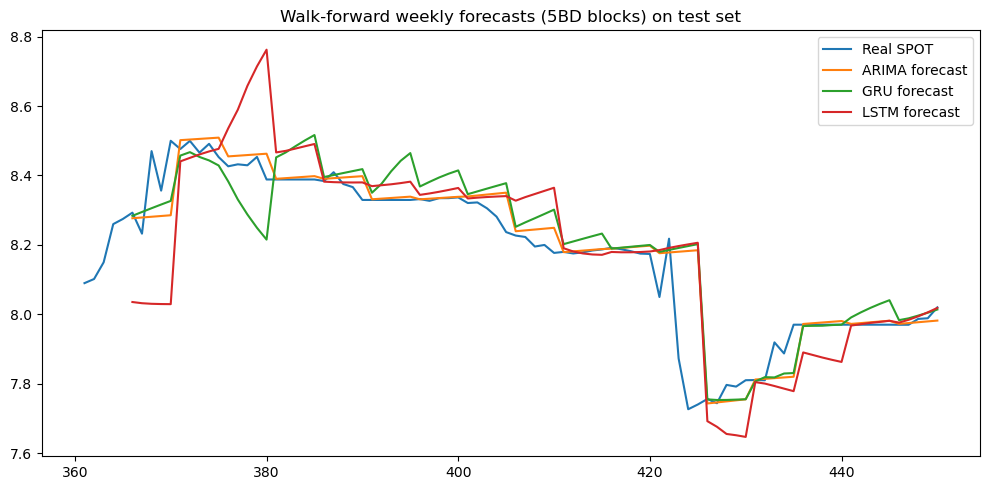

In [37]:
plt.figure(figsize=(10, 5))
plt.title("Walk-forward weekly forecasts (5BD blocks) on test set")
plt.plot(weekly_forecasts.index, weekly_forecasts["REAL_SPOT"], label="Real SPOT")
plt.plot(weekly_forecasts.index, weekly_forecasts["ARIMA_SPOT"], label="ARIMA forecast")
plt.plot(weekly_forecasts.index, weekly_forecasts["GRU_SPOT"], label="GRU forecast")
plt.plot(weekly_forecasts.index, weekly_forecasts["LSTM_SPOT"], label="LSTM forecast")
plt.legend()
plt.tight_layout()
plt.show()